In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import scipy.ndimage as ndimage

In [2]:
def bgr2rgb(img):
    b,g,r = cv.split(img)
    return cv.merge([r,g,b])

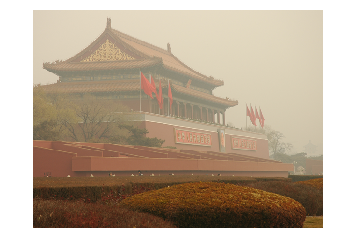

In [3]:
img = bgr2rgb(cv.imread("images/tiananmen1.bmp"))
plt.imshow(img)
plt.axis("off");

## Obtaining the Dark Channel Prior
The dark channel prior is defined as: $$J^{dark}(x) = \min_{c \in \{r,g,b\}}(\min_{y \in \Omega(x)}(J^{c}(y)))$$

$\mathbf{J}$ is our image, $J^{c}$ is defined as a color channel of our image (one of red, blue, or green), and $\Omega(x)$ is a patch of pixels centered at $x$. 

Intuitively, $J^{dark}$ should be low in a haze-free region of the image.

In [4]:
def get_dark_channel_prior(img, w_size=15):
    """
    img    -> 3D tensor in RGB format
    w_size -> size of patch to consider (default is 15)
    """    
    J_dark = ndimage.minimum_filter(img, footprint=np.ones((w_size,w_size,3)), mode='nearest')
            
    return J_dark[:,:,1]

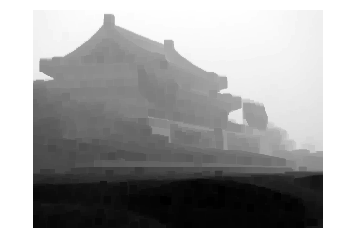

In [5]:
tian_jdark = get_dark_channel_prior(img)
plt.imshow(tian_jdark, cmap='gray')
plt.axis('off');

## Estimation of Atmospheric Light
We assume that the atmospheric light is a constant for each channel. Also, we calculate the atmospheric light for each channel in the image since Equation (6) references $A^{c}$, indicating that $A$ is different depending on what channel that is being used in the calculations.

The procedure is as follows:
1. Calculate the dark channel prior.
2. Pick the 0.1% brightest pixels in the dark channel.
3. Find the maximum intensity among the pixels in the original image $I$ for each of the channels.

In [6]:
def estimate_atmospheric_light(img, w_size=15):
    """
    img -> 3D tensor in RGB format
    
    ret -> 
        A_r |
        A_g | -> estimated atmospheric light in the RGB channels
        A_c |
    """
    size = img.shape[:2]
    k = int(0.001*np.prod(size))
    j_dark = get_dark_channel_prior(img, w_size=w_size)
    idx = np.argpartition(-j_dark.ravel(),k)[:k]
    x, y = np.hsplit(np.column_stack(np.unravel_index(idx, size)), 2)
    
    A = np.array([img[x,y,0].max(), img[x,y,1].max(), img[x,y,2].max()])
    return A

Here, we replicate the detection of atmospheric light, similar to figure 7 (first row, third column). The pixels we inspect for the atmospheric light is in the same region as that of the paper's.

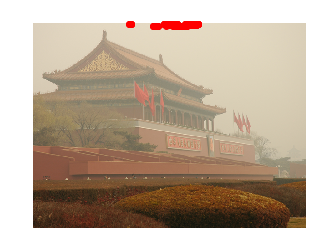

In [7]:
size = img.shape[:2]
k = int(0.001*np.prod(size))
idx = np.argpartition(-tian_jdark.ravel(),k)[:k]
zz = np.column_stack(np.unravel_index(idx, tian_jdark.shape))
x, y = np.hsplit(zz,2)
plt.imshow(img)
plt.scatter(y, x, c='r')
plt.axis('off')
plt.show();

## 4.1 Estimating the Transmission

In [8]:
def estimate_transmission(img, omega=0.95, w_size=15):
    """
    Estimates the transmission map using the dark channel prior of the normalized image. 
    A small fraction, omega, of the haze is kept to retain depth perspective after haze removal.
    
    img   -> 3D Tensor in RGB format
    omega -> fraction of haze to keep in image (default is 0.95)
    """
    A= estimate_atmospheric_light(img)
    norm_img = img / A
    norm_img_dc = get_dark_channel_prior(norm_img, w_size=w_size)

    return 1 - omega*norm_img_dc

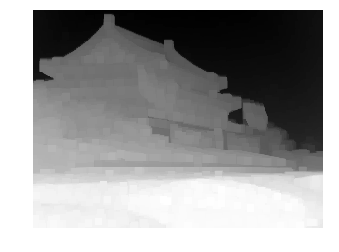

In [9]:
alpha_map = estimate_transmission(img)
plt.imshow(alpha_map, cmap='gray')
plt.axis("off");

We can vectorize the calculation of the guided filter by using two facts to calculate the covariance matrix for each patch:
1. $\Sigma_{ij} = cov(X_i, X_j) = \mathbb{E}[(X_i - \mu_i)(X_j - \mu_j)] = \mathbb{E}[X_iX_j] - \mu_i\mu_j$ [[1]](https://en.wikipedia.org/wiki/Covariance_matrix)
2. $\Sigma = \begin{bmatrix} \Sigma_{11} & \Sigma_{12} & \Sigma_{13} \\ \Sigma_{21} & \Sigma_{22} & \Sigma_{23} \\ \Sigma_{31} & \Sigma_{32} & \Sigma_{33}\end{bmatrix}$. Note that $\Sigma_{ij} = \Sigma_{ji}$.

This will generate the covariance matrix for each patch in equation (14) from [He et. al's guided filter paper](http://kaiminghe.com/publications/eccv10guidedfilter.pdf).

In [10]:
def guided_filter(I, p, omega=60, eps=0.01):
    """
    from http://kaiminghe.com/publications/eccv10guidedfilter.pdf
    and  https://arxiv.org/pdf/1505.00996.pdf
    
    I     -> guidance image, 3D Tensor in RGB format
    p     -> filtering input image, 
    omega -> window size (default is 60)
    eps   -> regularization parameter (default 0.01)
    """
    
    w_size = (omega,omega)
    I = I/255
    I_r, I_g, I_b = I[:,:,0], I[:,:,1], I[:,:,2]
    
    mean_I_r = cv.blur(I_r, w_size)
    mean_I_g = cv.blur(I_g, w_size)
    mean_I_b = cv.blur(I_b, w_size)
    
    mean_p = cv.blur(p, w_size)
    
    mean_Ip_r = cv.blur(I_r*p, w_size)
    mean_Ip_g = cv.blur(I_g*p, w_size)
    mean_Ip_b = cv.blur(I_b*p, w_size)
         
    cov_Ip_r =  mean_Ip_r - mean_I_r*mean_p
    cov_Ip_g =  mean_Ip_g - mean_I_g*mean_p
    cov_Ip_b =  mean_Ip_b - mean_I_b*mean_p
    cov_Ip = np.stack([cov_Ip_r, cov_Ip_g, cov_Ip_b], axis=-1)
    
    var_I_rr = cv.blur(I_r*I_r, w_size) - mean_I_r*mean_I_r
    var_I_rg = cv.blur(I_r*I_g, w_size) - mean_I_r*mean_I_g
    var_I_rb = cv.blur(I_r*I_b, w_size) - mean_I_r*mean_I_b
    var_I_gb = cv.blur(I_g*I_b, w_size) - mean_I_g*mean_I_b
    var_I_gg = cv.blur(I_g*I_g, w_size) - mean_I_g*mean_I_g
    var_I_bb = cv.blur(I_b*I_b, w_size) - mean_I_b*mean_I_b
    
    a = np.zeros(I.shape)
    for x, y in np.ndindex(I.shape[:2]):
        Sigma = np.array([
            [var_I_rr[x,y], var_I_rg[x,y], var_I_rb[x,y]],
            [var_I_rg[x,y], var_I_gg[x,y], var_I_gb[x,y]],
            [var_I_rb[x,y], var_I_gb[x,y], var_I_bb[x,y]]
        ])
        c = cov_Ip[x,y,:]
        
        a[x,y,:] = np.linalg.inv(Sigma + eps*np.eye(3)).dot(c)
        
    mean_a = np.stack([cv.blur(a[:,:,0], w_size), cv.blur(a[:,:,1], w_size), cv.blur(a[:,:,2], w_size)], axis=-1)
    mean_I = np.stack([mean_I_r, mean_I_g, mean_I_b], axis=-1)
    
    b = mean_p - np.sum(a*mean_I, axis=2)
    mean_b = cv.blur(b, w_size)
    q = np.sum(mean_a*I, axis=2) + mean_b
    
    return q

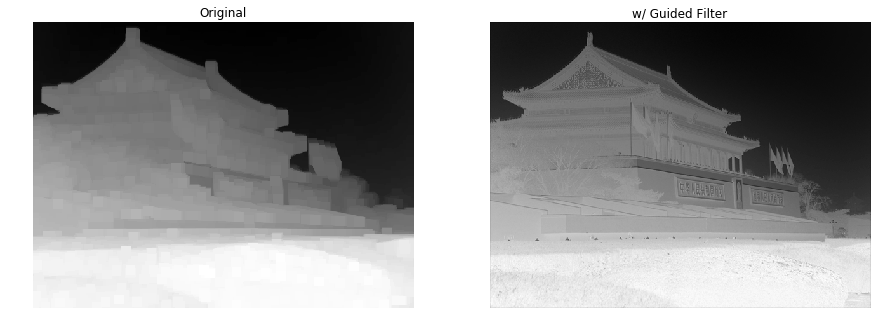

In [11]:
f_alpha_map = guided_filter(img, alpha_map, 200, eps=1e-3)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))

ax1.imshow(alpha_map, cmap="gray")
ax1.set_title("Original")
ax1.axis('off')

ax2.imshow(f_alpha_map, cmap="gray")
ax2.set_title("w/ Guided Filter")
ax2.axis('off');

In [12]:
def haze_removal(img, w_size=15, a_omega=0.95, gf_w_size=200, eps=1e-6):
    img = img.astype(np.int16)
    A = estimate_atmospheric_light(img, w_size=w_size)
    alpha_map = estimate_transmission(img, omega=a_omega, w_size=w_size)
    f_alpha_map = guided_filter(img, alpha_map, omega=gf_w_size, eps=eps)
    
    img[:,:,0] -= A[0]
    img[:,:,1] -= A[1]
    img[:,:,2] -= A[2]
    z = np.maximum(f_alpha_map, 0.1)
    img[:,:,0] = img[:,:,0]/z
    img[:,:,1] = img[:,:,1]/z
    img[:,:,2] = img[:,:,2]/z

    img[:,:,0] += A[0]
    img[:,:,1] += A[1]
    img[:,:,2] += A[2]

    img = np.maximum(img, 0)
    img = np.minimum(img, 255)
    
    return img

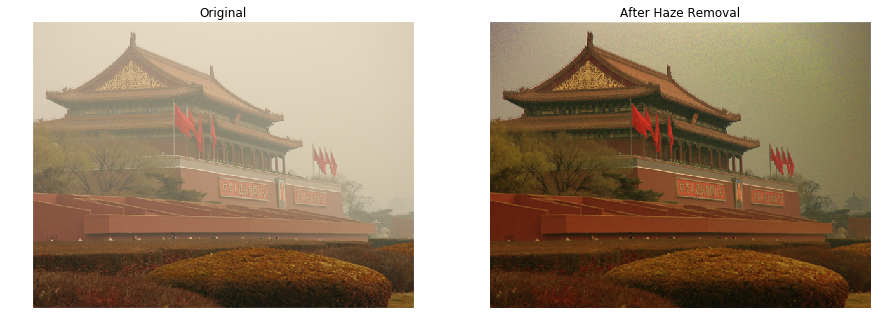

In [13]:
l = haze_removal(img, w_size=15, a_omega=0.95, gf_w_size=200, eps=1e-6)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))

ax1.imshow(img)
ax1.set_title("Original")
ax1.axis('off')

ax2.imshow(l)
ax2.set_title("After Haze Removal")
ax2.axis('off');